In [ ]:
# Each agent has a budget of 1025
# Evaluation has cost c=1, acting has cost A=25
# X axis is correlation
# Dotted line for fixed-K agents
# Solid line for dynamic

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

In [1]:
%load_ext autoreload

In [2]:
%autoreload

from dmaker.decision_maker import FixedDecisionMaker, DynamicDecisionMaker
from dmaker.environment import DecisionEnvironment

In [34]:
k_values = [1, 2, 4, 9, 20]
sigmas = [0.1, 1, 2, 3, 4, 5]
data = pd.DataFrame(index=sigmas)

for sigma in sigmas:
    env = DecisionEnvironment(N=1000, num_trials=100, sigma=sigma, mu=0, tau=1)
    dms = [FixedDecisionMaker(env, i) for i in k_values] + [DynamicDecisionMaker(env)]
    for dm in dms:
        dm.decide()
        data.loc[sigma, dm.name] = dm.data.utility.mean()

<AxesSubplot:>

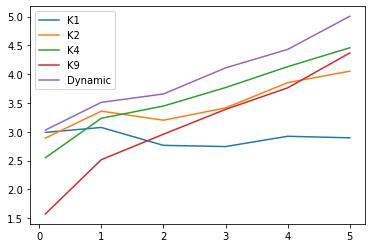

In [35]:
data.drop(columns="K20").plot()

In [4]:
# Changed from open ended/one-off costs to fixed budget/timeline situation
# Use correlation rho instead of sigma, use that as the X axis
# -> This will get graph similar to the one in Habits of thought, but without dotted lines and instead new line of optimal agent
# Also do one with cost of evaluation on the x axis

# Follow this up with analysis of dynamic agent's probability of stopping as a function of value of action last evaluated

# Adapted from Matlab code in https://github.com/adammmorris/consideration-sets/blob/master/simulations/sims.m
import numpy as np
import matplotlib.pyplot as plt

MU_VHAT = 0
MU_V = 0
VARIANCE = 1
BASE_BUDGET = 1000

# vals has the structure [[vhat_1, v_1], [vhat_2, v_2], ...]
# vals must be sorted by vhats before being passed to this decision function
def fixed_k_decide(k, action_cost):
    def decide(vals, _): # Don't do anything with additional parameter
        considerat_set = vals[:k,1]
        utility = max(considerat_set)
        budget = BASE_BUDGET + action_cost
        budget -= k * action_cost # for consideration time
        actions_taken = (budget // action_cost)
        return actions_taken * utility
    return decide

def dynamic_decide(action_cost):
    num_simulations = 100
    def decide(vals, cur_r):
        sigma = [[variance, cur_r * variance], [cur_r * variance, variance]]
        # determine how many you would want to take in similar situations, then go with that
        budget = BASE_BUDGET + action_cost
        num_actions_left = [(budget - i*action_cost) // action_cost for i in range(len(vals))]
        
        # conditional on vhat, the vs are distributed normal with updated mean and variance
        #https://stats.stackexchange.com/questions/30588/deriving-the-conditional-distributions-of-a-multivariate-normal-distribution
        new_mu = MU_V + (VARIANCE * cur_r)/VARIANCE * (vals[:,0]-MU_VHAT)
        new_variance = VARIANCE - (VARIANCE * cur_r)*(VARIANCE * cur_r)/VARIANCE
        
        sim_vals = np.random.multivariate_normal(new_mu, np.diag([new_variance]*len(vals[:,0])), num_simulations)
        max_sim_vals = np.maximum.accumulate(sim_vals, axis=1)
        mean_total_sim_util = np.mean(max_sim_vals * num_actions_left, axis=0) # take cumulative max first, then means

        num_eval = np.argmax(mean_total_sim_util)+1 # zero-indexed
        consideration_set = vals[:num_eval,1]
        utility = max(consideration_set)
        budget -= num_eval * action_cost # for consideration time
        actions_taken = (budget // action_cost)        
        return actions_taken * utility
    return decide

def optimal_decide(action_cost):
    def decide(vals, cur_r):
        budget = BASE_BUDGET + action_cost
        num_actions_left = [(budget - i*action_cost) // action_cost for i in range(len(vals))]
        max_vals = np.maximum.accumulate(vals[:,1])
        total_util = max_vals * num_actions_left
        num_eval = np.argmax(total_util)+1 # zero-indexed
        consideration_set = vals[:num_eval,1]
        utility = max(consideration_set)
        budget -= num_eval * action_cost # for consideration time
        actions_taken = (budget // action_cost)
        return actions_taken * utility
    return decide

In [120]:
num_actions_all = [20, 100, 1000]
action_costs_all = [2, 5, 10, 25, 50, 100]

results_cols = ["num_actions", "action_cost", "r", "agent", "utility"]
results = pd.DataFrame(columns=results_cols)

for num_actions in num_actions_all:
    print("num_actions", num_actions)
    for action_cost in action_costs_all:
        k_agents = [1, 2, 3, 4, 5, 7, 9, 12, 15, 20]
        if num_actions > 20:
            k_agents += [40, 80, num_actions]
        agents = {k: fixed_k_decide(k, action_cost) for k in k_agents}
        agents["Optimal"] = optimal_decide(action_cost)
        agents["Dynamic"] = dynamic_decide(action_cost)
        
        
        r_all = [0.25, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95, 1] # [0, .25, .5, .75, 1]
        
        n_envs = len(r_all)
        variance = VARIANCE
        mu = [MU_VHAT, MU_V]
        
        num_trials = 100 #10000
        
        for cur_r in r_all:            
            sigma = [[variance, cur_r * variance], [cur_r * variance, variance]]
            
            temp_results = {agent: [] for agent in agents.keys()}
            
            for trial in range(num_trials):
                vals = np.random.multivariate_normal(mu, sigma, num_actions)
                indices = np.argsort(-vals[:,0])
                vals = np.take_along_axis(vals, np.stack([indices, indices], axis=1), axis=0)

                # evaluate for all agents
                for agent_name, agent_func in agents.items():
                    temp_results[agent_name].append(agent_func(vals, cur_r))
            
            rows = [[num_actions, action_cost, cur_r, agent, np.mean(temp_results[agent])] for agent in temp_results.keys()]
            results = results.append(pd.DataFrame(rows, columns=results_cols))


num_actions 20
num_actions 100
num_actions 1000


In [122]:
results.to_csv("~/Desktop/thesis/simulation/results.csv")

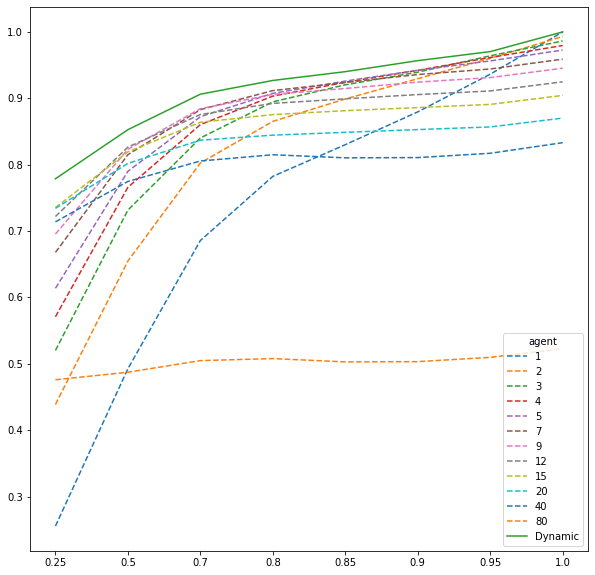

In [134]:
# Performance as a function of correlation rho

to_plot = results.groupby(["agent", "r"]).agg({"utility": "mean"}).reset_index()

to_plot = to_plot[(to_plot["agent"]!=1000)&(to_plot["agent"]!=100)&(to_plot["agent"]!="Optimal")]

to_plot["utility"] += min(to_plot["utility"]) * ((min(to_plot["utility"]) <= 0)  * (-1))
to_plot["utility"] /= max(to_plot["utility"])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

for agent in to_plot["agent"].unique():
    subset = to_plot[to_plot["agent"]==agent].copy()
    linestyle = None if agent in ["Dynamic", "Optimal"] else "dashed"
    plt.plot(subset["r"].apply(lambda x: str(x)), subset["utility"], label=agent, linestyle=linestyle)
plt.legend(title="agent")

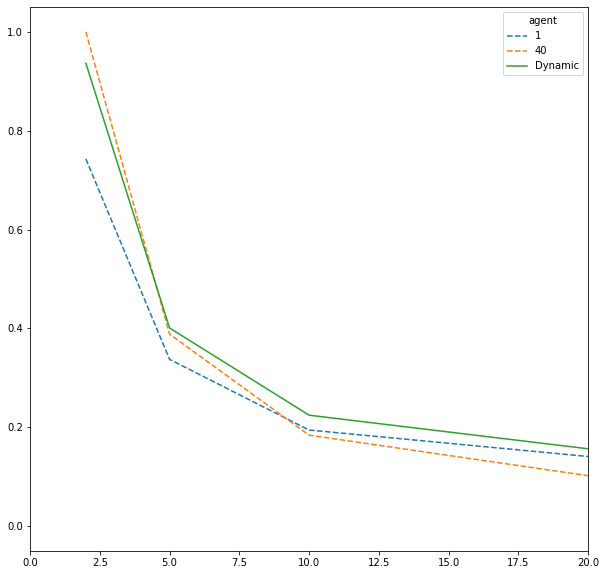

In [128]:
# Perfromance as a funcion of action cost

to_plot = results.groupby(["agent", "action_cost"]).agg({"utility": "mean"}).reset_index()
to_plot = to_plot[(to_plot["agent"]==1)|(to_plot["agent"]==40)|(to_plot["agent"]=="Dynamic")]

to_plot["utility"] += min(to_plot["utility"]) * ((min(to_plot["utility"]) <= 0)  * (-1))
to_plot["utility"] /= max(to_plot["utility"])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim((0, 20))

for agent in to_plot["agent"].unique():
    subset = to_plot[to_plot["agent"]==agent].copy()
    linestyle = None if agent in ["Dynamic", "Optimal"] else "dashed"
    plt.plot(subset["action_cost"], subset["utility"], label=agent, linestyle=linestyle)
plt.legend(title="agent")

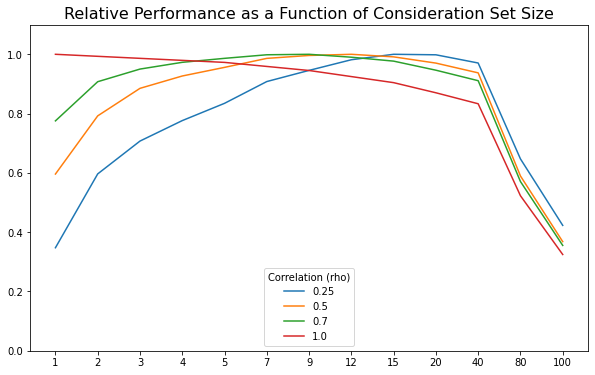

In [153]:
# Replicating Adam's simulation results

to_plot = results.groupby(["agent", "r"]).agg({"utility": "mean"}).reset_index()
to_plot = to_plot[(to_plot["agent"]!="Optimal")&(to_plot["agent"]!="Dynamic")&(to_plot["agent"]!=1000)]
to_plot = to_plot[(to_plot["r"]==0.25)|(to_plot["r"]==0.5)|(to_plot["r"]==0.7)|(to_plot["r"]==1)]

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_ylim((0.0, 1.1))

for r in to_plot["r"].unique():
    subset = to_plot[to_plot["r"]==r].copy()
    subset["utility"] += min(subset["utility"]) * ((min(subset["utility"]) <= 0)  * (-1))
    subset["utility"] /= max(subset["utility"])
    plt.plot(subset["agent"].apply(lambda x: str(x)), subset["utility"], label=r)
plt.legend(title="Correlation (rho)", loc="lower center")
plt.title("Relative Performance as a Function of Consideration Set Size", size=16)
plt.show()

In [5]:
# Run again and keep more data on consideration set, so that we can reconstruct probability of stopping
# Need last column, and value column for dynamic decision maker
# Can just re-use code above but keep vals[:,1], the v values

def dynamic_decide(action_cost):
    num_simulations = 100
    def decide(vals, cur_r):
        sigma = [[variance, cur_r * variance], [cur_r * variance, variance]]
        # determine how many you would want to take in similar situations, then go with that
        budget = BASE_BUDGET + action_cost
        num_actions_left = [(budget - i*action_cost) // action_cost for i in range(len(vals))]
        
        # conditional on vhat, the vs are distributed normal with updated mean and variance
        #https://stats.stackexchange.com/questions/30588/deriving-the-conditional-distributions-of-a-multivariate-normal-distribution
        new_mu = MU_V + (VARIANCE * cur_r)/VARIANCE * (vals[:,0]-MU_VHAT)
        new_variance = VARIANCE - (VARIANCE * cur_r)*(VARIANCE * cur_r)/VARIANCE
        
        sim_vals = np.random.multivariate_normal(new_mu, np.diag([new_variance]*len(vals[:,0])), num_simulations)
        max_sim_vals = np.maximum.accumulate(sim_vals, axis=1)
        mean_total_sim_util = np.mean(max_sim_vals * num_actions_left, axis=0) # take cumulative max first, then means

        num_eval = np.argmax(mean_total_sim_util)+1 # zero-indexed
        consideration_set = vals[:num_eval,1]
        utility = max(consideration_set)
        budget -= num_eval * action_cost # for consideration time
        actions_taken = (budget // action_cost)        
        return actions_taken * utility, (num_eval, utility)
    return decide

num_actions_all = [20, 100, 1000]
action_costs_all = [2, 5, 10, 25, 50, 100]

results_cols = ["num_actions", "action_cost", "r", "agent", "order", "value", "last"]
results = pd.DataFrame(columns=results_cols)

for num_actions in num_actions_all:
    print("num_actions", num_actions)
    for action_cost in action_costs_all:
        agent_func = dynamic_decide(action_cost)
        
        r_all = [0.25, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95, 1] # [0, .25, .5, .75, 1]
        
        n_envs = len(r_all)
        variance = VARIANCE
        mu = [MU_VHAT, MU_V]
        
        num_trials = 100 #10000
        
        for cur_r in r_all:            
            sigma = [[variance, cur_r * variance], [cur_r * variance, variance]]
            
            temp_results = []
            
            for trial in range(num_trials):
                vals = np.random.multivariate_normal(mu, sigma, num_actions)
                indices = np.argsort(-vals[:,0])
                vals = np.take_along_axis(vals, np.stack([indices, indices], axis=1), axis=0)
                
                total_utility, (num_eval, utility) = agent_func(vals, cur_r)
                
                rows = pd.DataFrame({"value": vals[:,1]})
                rows["num_actions"] = num_actions
                rows["action_cost"] = action_cost
                rows["r"] = cur_r
                rows["agent"] = "Dynamic"
                rows["order"] = list(range(len(vals[:,1])))
                rows["last"] = rows["value"] == utility
                
                if sum(rows["last"]) != 1:
                    breakpoint()
                            
            results = results.append(rows)

num_actions 20
num_actions 100
num_actions 1000


In [6]:
results.to_csv("~/Desktop/thesis/simulation/experiment_prediction_results.csv")

In [7]:
results

,num_actions,action_cost,r,agent,order,value,last
0,20,2,0.25,Dynamic,0,1.352005,True
1,20,2,0.25,Dynamic,1,-0.342851,False
2,20,2,0.25,Dynamic,2,-0.756022,False
3,20,2,0.25,Dynamic,3,-0.531289,False
4,20,2,0.25,Dynamic,4,0.552963,False
...,...,...,...,...,...,...,...
995,1000,100,1.00,Dynamic,995,-2.759841,False
996,1000,100,1.00,Dynamic,996,-2.816337,False
997,1000,100,1.00,Dynamic,997,-2.877217,False
998,1000,100,1.00,Dynamic,998,-3.158497,False


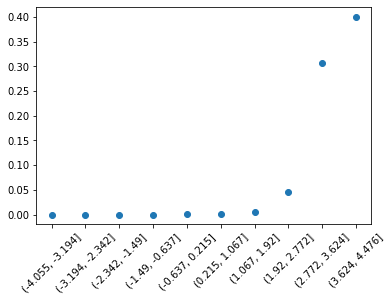

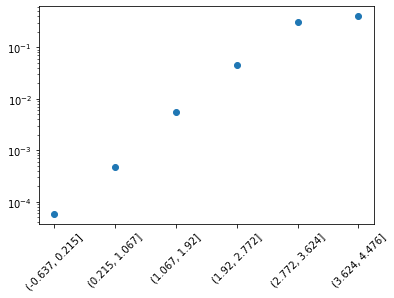

In [57]:
results["value_bin"] = pd.cut(results["value"], 10)
results["last"] = results["last"].astype(int)
to_plot = results.groupby("value_bin").agg({"last": "mean", "order": "count"}).reset_index()
to_plot["value_bin"] = to_plot["value_bin"].astype(str)

plt.scatter(to_plot["value_bin"], to_plot["last"])
plt.xticks(rotation=45)
plt.show()


plt.scatter(to_plot.loc[4:, "value_bin"], to_plot.loc[4:, "last"])
plt.xticks(rotation=45)
plt.yscale("log")
plt.show()

In [32]:
to_plot

,value_bin,last,order
0,"(-4.055, -3.194]",0.000000,36
1,"(-3.194, -2.342]",0.000000,425
2,"(-2.342, -1.49]",0.000000,3315
3,"(-1.49, -0.637]",0.000000,10479
4,"(-0.637, 0.215]",0.000058,17102
5,"(0.215, 1.067]",0.000477,14684
6,"(1.067, 1.92]",0.005589,6262
7,"(1.92, 2.772]",0.045283,1325
8,"(2.772, 3.624]",0.307087,127
9,"(3.624, 4.476]",0.400000,5
